In [168]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)



from queries.query import Query
import testing.tpch.setup as tpch_setup

In [169]:
# Small dataset, 500 queries - m1, m2, m3 ...
RESULTS_PATH = "../results/load-based-N-fields/tpch/2025-03-26-15H/"

results_df = pd.read_csv(RESULTS_PATH + "meta_results.csv")
results_df = results_df[["Test", "Load", "Total query time",
                         "Materialized Columns", "Materialization"]]
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Test                  210 non-null    object 
 1   Load                  210 non-null    int64  
 2   Total query time      210 non-null    float64
 3   Materialized Columns  210 non-null    int64  
 4   Materialization       210 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 8.3+ KB


In [170]:
results_df["Test"].unique()

array(['load_based_m1', 'load_based_m2', 'load_based_m3', 'load_based_m4',
       'load_based_m5', 'load_based_m6', 'load_based_m7', 'load_based_m8',
       'load_based_m9', 'load_based_m10', 'load_based_m11',
       'load_based_m12', 'load_based_m13', 'load_based_m14',
       'load_based_m15', 'load_based_m20', 'load_based_m25',
       'load_based_m30', 'load_based_m35', 'full_materialization',
       'schema_based_materialization'], dtype=object)

In [171]:
# Only look at load-based tests
results_df = results_df[results_df["Test"] != "full_materialization"]
results_df = results_df[results_df["Test"] != "schema_based_materialization"]
results_df = results_df[results_df["Test"] != "load_based_m20"]
results_df = results_df[results_df["Test"] != "load_based_m25"]
results_df = results_df[results_df["Test"] != "load_based_m30"]
results_df = results_df[results_df["Test"] != "load_based_m35"]
results_df

,Test,Load,Total query time,Materialized Columns,Materialization
0,load_based_m1,0,1737.077425,1,['l_extendedprice']
1,load_based_m2,0,1717.975765,2,"['l_extendedprice', 'l_discount']"
2,load_based_m3,0,1558.094478,3,"['l_extendedprice', 'l_discount', 'l_shipdate']"
3,load_based_m4,0,1472.273624,4,"['l_extendedprice', 'l_discount', 'l_shipdate'..."
4,load_based_m5,0,1176.333647,5,"['l_extendedprice', 'l_discount', 'l_shipdate'..."
...,...,...,...,...,...
199,load_based_m11,9,1157.910905,11,"['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n..."
200,load_based_m12,9,1139.622765,12,"['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n..."
201,load_based_m13,9,1128.036697,13,"['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n..."
202,load_based_m14,9,1033.407076,14,"['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n..."


In [172]:
# Get the materialized column
results_df["Materialized Column"] = results_df.apply(
    lambda row: row["Materialization"].strip('[').strip(']').split(', ')[-1].strip("'"), axis=1)
results_df

,Test,Load,Total query time,Materialized Columns,Materialization,Materialized Column
0,load_based_m1,0,1737.077425,1,['l_extendedprice'],l_extendedprice
1,load_based_m2,0,1717.975765,2,"['l_extendedprice', 'l_discount']",l_discount
2,load_based_m3,0,1558.094478,3,"['l_extendedprice', 'l_discount', 'l_shipdate']",l_shipdate
3,load_based_m4,0,1472.273624,4,"['l_extendedprice', 'l_discount', 'l_shipdate'...",p_partkey
4,load_based_m5,0,1176.333647,5,"['l_extendedprice', 'l_discount', 'l_shipdate'...",s_suppkey
...,...,...,...,...,...,...
199,load_based_m11,9,1157.910905,11,"['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n...",ps_suppkey
200,load_based_m12,9,1139.622765,12,"['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n...",p_type
201,load_based_m13,9,1128.036697,13,"['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n...",l_discount
202,load_based_m14,9,1033.407076,14,"['o_orderkey', 's_suppkey', 'l_orderkey', 'n_n...",p_size


In [173]:
# Get the reduction in execution time

# Remove all tests where only one column was materialized

# Extract relevant columns
results_df = results_df[["Load", "Materialized Column",
                         "Total query time", "Materialized Columns"]]

# Make sure the tests are sorted based on 1. Load, 2. Materialized Columns
results_df.sort_values(["Load", "Materialized Columns"], inplace=True)

# Get the reduction in execution time
results_df["Time gain"] = results_df["Total query time"].shift(
    1) - results_df["Total query time"]

results_df = results_df[results_df["Materialized Columns"] != 1]

# Extract relevant columns
results_df = results_df[["Load", "Materialized Column",
                         "Time gain"]]


results_df["Rounded time gain"] = results_df.apply(lambda row: int(round(row["Time gain"], -1)), axis=1)

sorted_results_df = results_df.sort_values(["Load", "Time gain"])

/var/folders/0j/09kq_s112r5gz6_30yv10dwr0000gn/T/ipykernel_87020/1795139272.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.sort_values(["Load", "Materialized Columns"], inplace=True)
/var/folders/0j/09kq_s112r5gz6_30yv10dwr0000gn/T/ipykernel_87020/1795139272.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["Time gain"] = results_df["Total query time"].shift(


In [174]:
print(sorted_results_df.head(30))


    Load Materialized Column   Time gain  Rounded time gain
8      0              s_name   -0.284711                  0
10     0             s_phone   -0.142150                  0
9      0           s_address    0.684334                  0
1      0          l_discount   19.101660                 20
11     0           l_partkey   25.143749                 30
12     0          o_orderkey   26.261542                 30
14     0         s_nationkey   31.239494                 30
5      0              n_name   37.864428                 40
13     0          l_orderkey   44.261353                 40
7      0              p_type   71.845353                 70
3      0           p_partkey   85.820854                 90
6      0         n_nationkey  140.905746                140
2      0          l_shipdate  159.881288                160
4      0           s_suppkey  295.939977                300
35     1         s_nationkey   10.813703                 10
32     1           p_partkey   11.341988

In [175]:
# Add frequency of occurence for the materialized column across the load

load_nos = results_df["Load"].unique()

loads = defaultdict(list)

for load_no in load_nos:
    with open(f"../loads/without_q5/load{load_no}.txt", mode="r") as file:
        load_string = file.read()
    load = load_string.strip("['").strip("']").split("', '")
    assert "q5" not in load
    loads[load_no] = load

query_freq = {load_no: {q: load.count(q) for q in load}  for load_no, load in loads.items()}

In [176]:
queries = tpch_setup.QUERIES

In [177]:
# Add frequency of occurence for the materialized column across the load

def get_field_frequency(load_no, materialized_column):
    load = loads[load_no]
    frequency = 0
    for query_name in set(load):
        cols = queries[query_name].columns_used()
        if materialized_column in cols:
            frequency += load.count(query_name)

    return frequency

results_df["Frequency"] = results_df.apply(
    lambda row: get_field_frequency(row["Load"], row["Materialized Column"]), axis=1
)
results_df

,Load,Materialized Column,Time gain,Rounded time gain,Frequency
1,0,l_discount,19.101660,20,351
2,0,l_shipdate,159.881288,160,248
3,0,p_partkey,85.820854,90,247
4,0,s_suppkey,295.939977,300,225
5,0,n_name,37.864428,40,223
...,...,...,...,...,...
199,9,ps_suppkey,19.222273,20,143
200,9,p_type,18.288140,20,140
201,9,l_discount,11.586068,10,140
202,9,p_size,94.629621,90,137


In [178]:
# Add frequency of occurence in a join for the materialized column across the load

def get_field_absolute_join_frequency(load_no, materialized_column):
    load = loads[load_no]
    frequency = 0
    for query_name in set(load):
        cols = queries[query_name].columns_used_with_position()["join"]
        if materialized_column in cols:
            frequency += load.count(query_name)

    return frequency


results_df["Join Frequency"] = results_df.apply(
    lambda row: get_field_absolute_join_frequency(row["Load"], row["Materialized Column"]), axis=1
)

In [179]:
# Add frequency of occurence in a where for the materialized column across the load

def get_field_absolute_where_frequency(load_no, materialized_column):
    load = loads[load_no]
    frequency = 0
    for query_name in set(load):
        cols = queries[query_name].columns_used_with_position()["where"]
        if materialized_column in cols:
            frequency += load.count(query_name)

    return frequency


results_df["Where Frequency, Absolute"] = results_df.apply(
    lambda row: get_field_absolute_where_frequency(row["Load"], row["Materialized Column"]), axis=1
)

In [180]:
# Add frequency of occurence in a select for the materialized column across the load

def get_field_absolute_select_frequency(load_no, materialized_column):
    load = loads[load_no]
    frequency = 0
    for query_name in set(load):
        cols = queries[query_name].columns_used_with_position()["select"]
        if materialized_column in cols:
            frequency += load.count(query_name)

    return frequency


results_df["Select Frequency, Absolute"] = results_df.apply(
    lambda row: get_field_absolute_select_frequency(row["Load"], row["Materialized Column"]), axis=1
)

In [181]:
# Add frequency of occurence in a group_by for the materialized column across the load

def get_field_absolute_group_by_frequency(load_no, materialized_column):
    load = loads[load_no]
    frequency = 0
    for query_name in set(load):
        cols = queries[query_name].columns_used_with_position()["group_by"]
        if materialized_column in cols:
            frequency += load.count(query_name)

    return frequency


results_df["Group By Frequency, Absolute"] = results_df.apply(
    lambda row: get_field_absolute_group_by_frequency(row["Load"], row["Materialized Column"]), axis=1
)

In [182]:
# Add frequency of occurence in a order_by for the materialized column across the load

def get_field_absolute_order_by_frequency(load_no, materialized_column):
    load = loads[load_no]
    frequency = 0
    for query_name in set(load):
        cols = queries[query_name].columns_used_with_position()["order_by"]
        if materialized_column in cols:
            frequency += load.count(query_name)

    return frequency


results_df["Order By Frequency, Absolute"] = results_df.apply(
    lambda row: get_field_absolute_order_by_frequency(row["Load"], row["Materialized Column"]), axis=1
)

In [183]:
sorted_results_df = results_df.sort_values("Rounded time gain", ascending=False)
# sorted_results_df[[
#     "Rounded time gain",
#     "Materialized Column", 
#     "Frequency", 
#     "Join Frequency", 
#     "Where Frequency, Absolute",
#     "Select Frequency, Absolute",
#     "Group By Frequency, Absolute",
#     "Order By Frequency, Absolute", 
# ]].head(30)
sorted_results_df.head(30)

,Load,Materialized Column,Time gain,Rounded time gain,Frequency,Join Frequency,"Where Frequency, Absolute","Select Frequency, Absolute","Group By Frequency, Absolute","Order By Frequency, Absolute"
108,5,l_orderkey,431.670861,430,319,319,107,6,6,0
107,5,c_custkey,330.802550,330,335,335,6,315,199,116
43,2,s_suppkey,327.188128,330,255,238,17,21,0,12
4,0,s_suppkey,295.939977,300,225,215,7,97,0,93
87,4,s_suppkey,303.890265,300,241,230,7,17,0,7
191,9,l_orderkey,262.571839,260,230,230,16,3,3,0
195,9,c_custkey,249.892626,250,210,210,7,186,98,88
94,4,ps_suppkey,242.196450,240,217,211,10,10,0,0
154,7,s_suppkey,230.963791,230,136,127,12,11,0,6
68,3,s_suppkey,230.248932,230,238,142,97,16,0,9


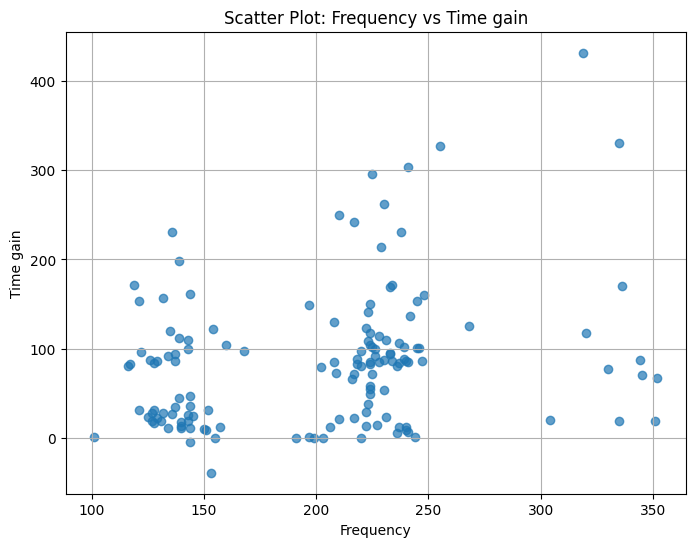

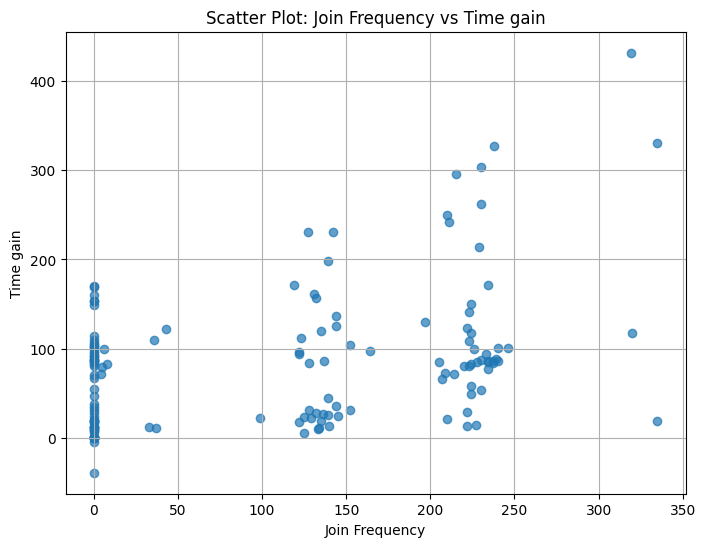

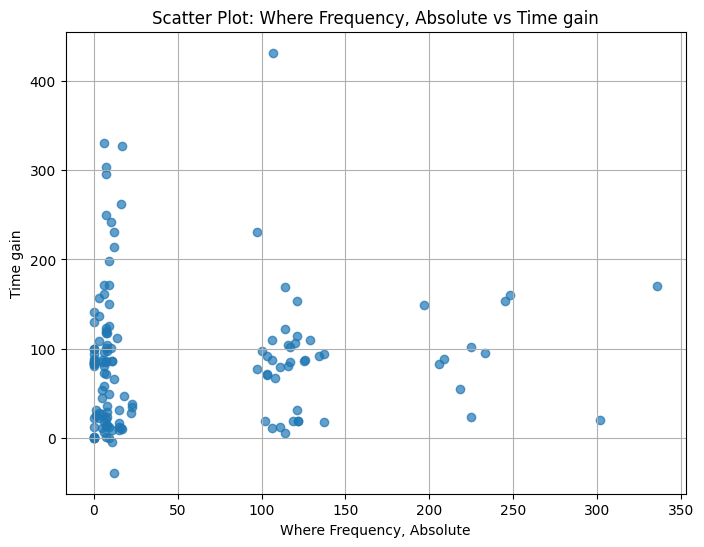

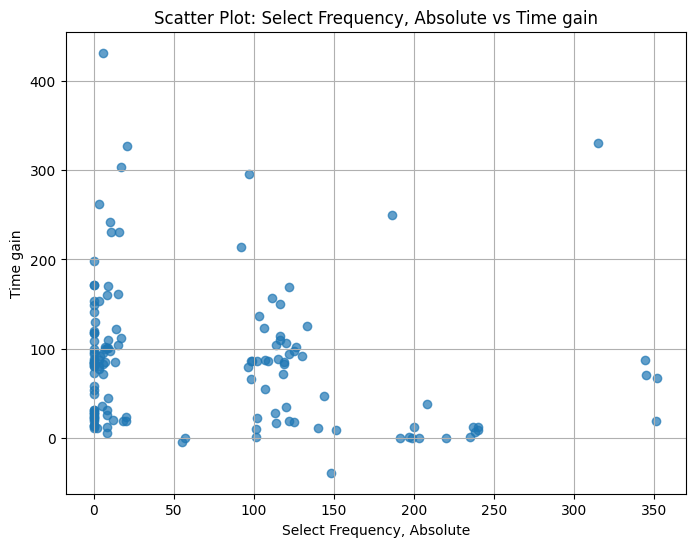

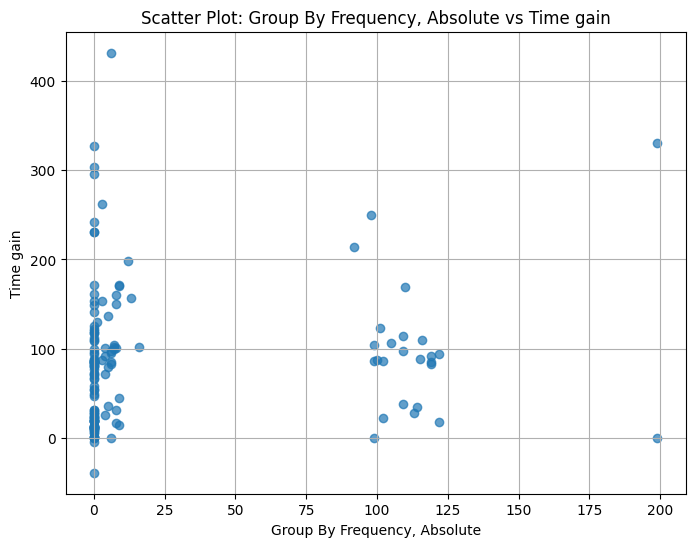

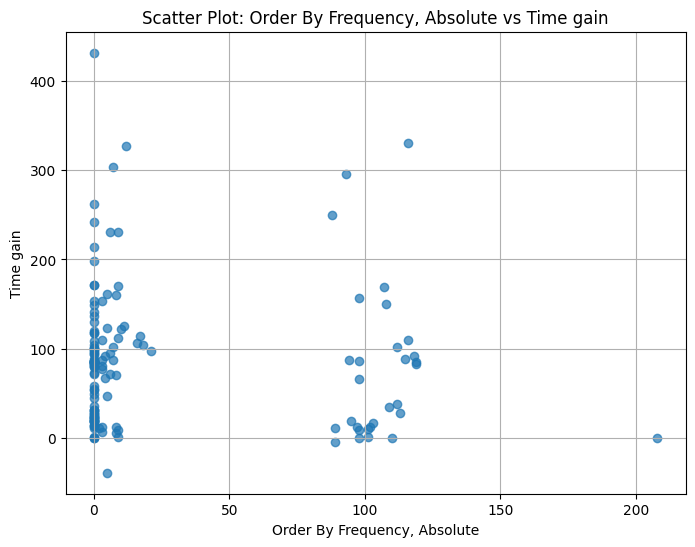

In [184]:
import matplotlib.pyplot as plt

# List of frequency columns to plot
frequency_columns = [
    'Frequency',
    'Join Frequency',
    'Where Frequency, Absolute',
    'Select Frequency, Absolute',
    'Group By Frequency, Absolute',
    'Order By Frequency, Absolute'
]

# Create scatter plots for each frequency column vs. 'Rounded time gain'
for col in frequency_columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(results_df[col], results_df['Time gain'], alpha=0.7)
    plt.xlabel(col)
    plt.ylabel("Time gain")
    plt.title(f"Scatter Plot: {col} vs Time gain")
    plt.grid(True)
    plt.show()

In [185]:
grouped_results_df = results_df[[
    'Materialized Column',
    'Time gain',
    'Rounded time gain',
    'Frequency',
    'Join Frequency',
    'Where Frequency, Absolute',
    'Select Frequency, Absolute',
    'Group By Frequency, Absolute',
    'Order By Frequency, Absolute'
]].groupby("Materialized Column").agg(['max', 'min', 'sum']).reset_index()

# Optional: Flatten the MultiIndex columns for easier access
grouped_results_df.columns = ['_'.join(col).strip(
    '_') for col in grouped_results_df.columns.values]

grouped_results_df.sort_values("Time gain_sum", inplace=True, ascending=False)


grouped_results_df.head(30)

,Materialized Column,Time gain_max,Time gain_min,Time gain_sum,Rounded time gain_max,Rounded time gain_min,Rounded time gain_sum,Frequency_max,Frequency_min,Frequency_sum,...,"Where Frequency, Absolute_sum","Select Frequency, Absolute_max","Select Frequency, Absolute_min","Select Frequency, Absolute_sum","Group By Frequency, Absolute_max","Group By Frequency, Absolute_min","Group By Frequency, Absolute_sum","Order By Frequency, Absolute_max","Order By Frequency, Absolute_min","Order By Frequency, Absolute_sum"
29,s_suppkey,327.188128,109.403294,2018.235720,330,110,2020,268,136,1943,...,389,133,9,350,0,0,0,93,3,165
5,l_orderkey,431.670861,31.452499,1293.463326,430,30,1290,319,139,1933,...,195,102,3,332,102,3,332,0,0,0
0,c_custkey,330.802550,87.128512,1097.784035,330,90,1100,335,132,1353,...,37,315,106,941,199,8,519,116,5,422
12,n_nationkey,140.905746,80.455395,925.507727,140,80,910,239,128,2095,...,0,0,0,0,0,0,0,0,0,0
11,n_name,168.646238,16.748884,874.958620,170,20,870,239,128,2095,...,852,208,114,1295,119,8,898,118,16,733
9,l_shipdate,170.067992,87.101721,858.708447,170,90,860,336,126,1547,...,1547,9,3,40,9,3,40,9,3,40
27,s_nationkey,171.416449,10.813703,576.316016,170,10,570,234,122,1593,...,60,0,0,0,0,0,0,0,0,0
16,o_orderkey,136.417215,26.261542,550.237532,140,30,550,245,143,1199,...,32,103,8,158,7,4,32,0,0,0
6,l_partkey,117.601793,25.143749,467.488968,120,30,480,320,136,1257,...,30,0,0,0,0,0,0,0,0,0
18,p_partkey,85.820854,5.288737,420.236992,90,10,430,330,144,1941,...,375,101,2,327,0,0,0,101,2,327


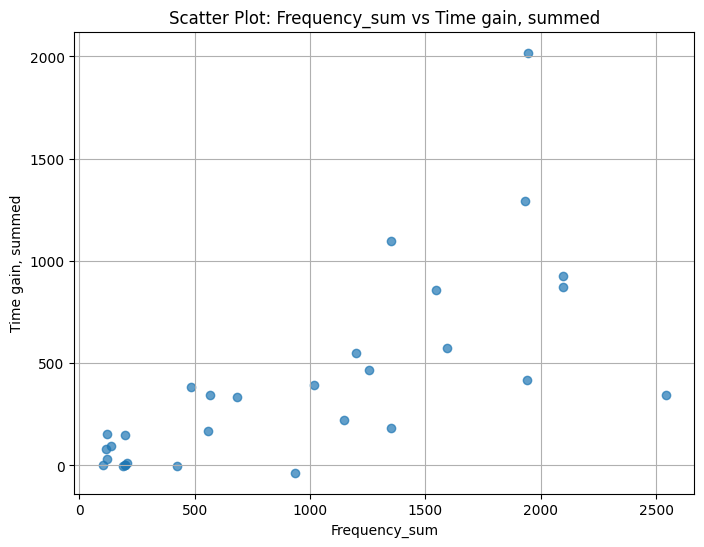

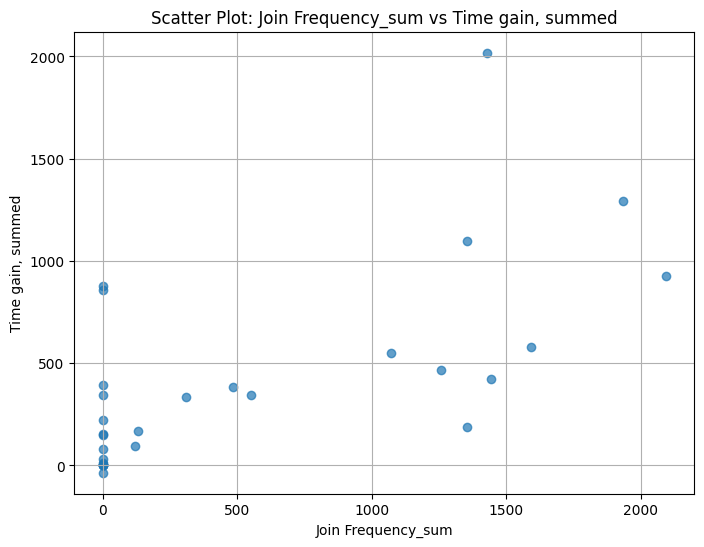

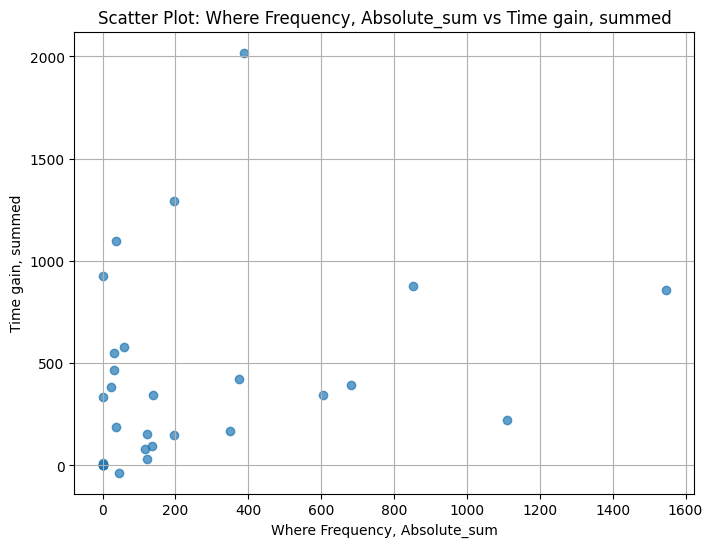

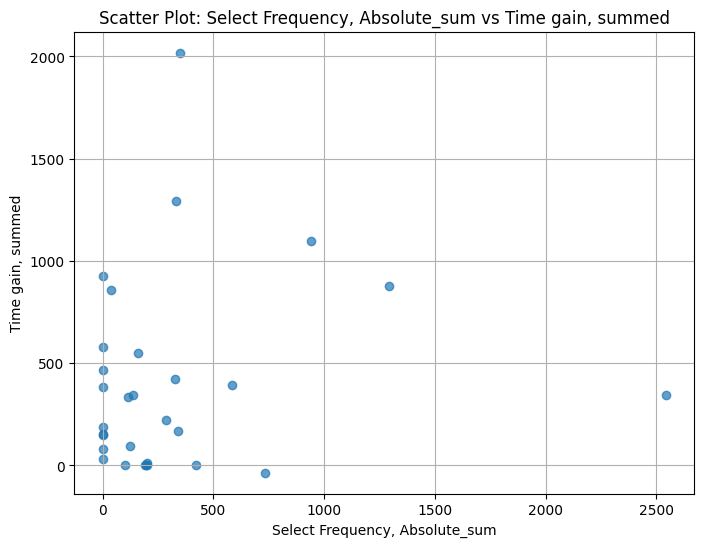

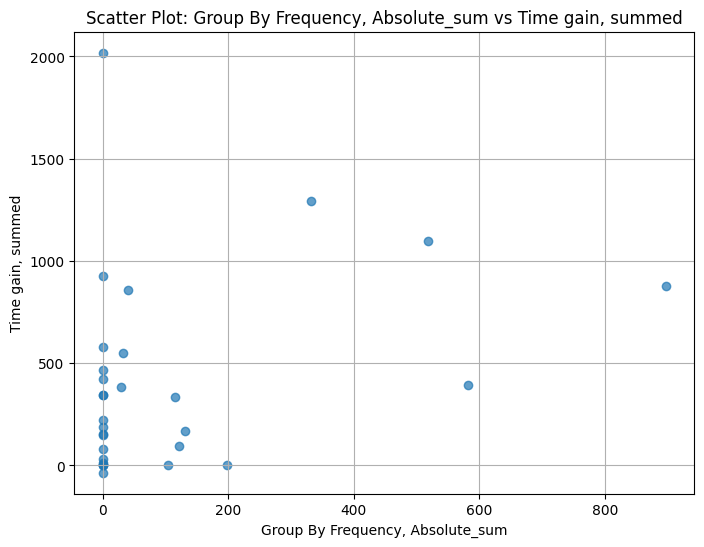

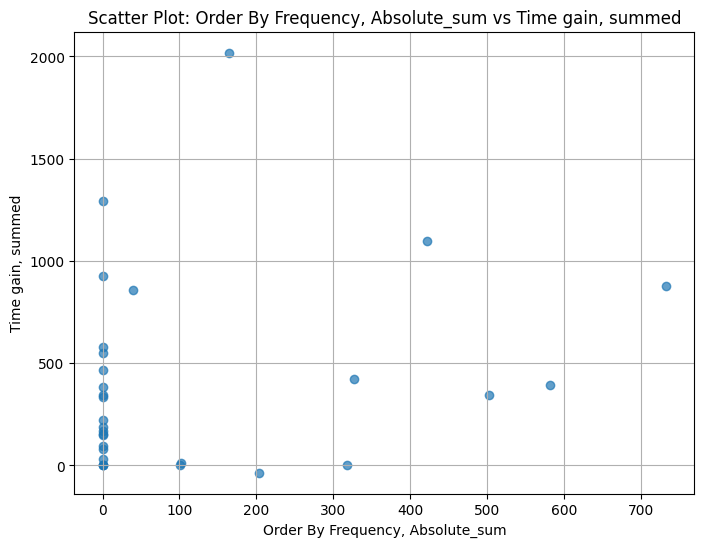

In [186]:
import matplotlib.pyplot as plt

# List of frequency columns to plot
frequency_columns = [
    'Frequency_sum',
    'Join Frequency_sum',
    'Where Frequency, Absolute_sum',
    'Select Frequency, Absolute_sum',
    'Group By Frequency, Absolute_sum',
    'Order By Frequency, Absolute_sum'
]

# Create scatter plots for each frequency column vs. 'Rounded time gain'
for col in frequency_columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(grouped_results_df[col], grouped_results_df['Time gain_sum'], alpha=0.7)
    plt.xlabel(col)
    plt.ylabel("Time gain, summed")
    plt.title(f"Scatter Plot: {col} vs Time gain, summed")
    plt.grid(True)
    plt.show()

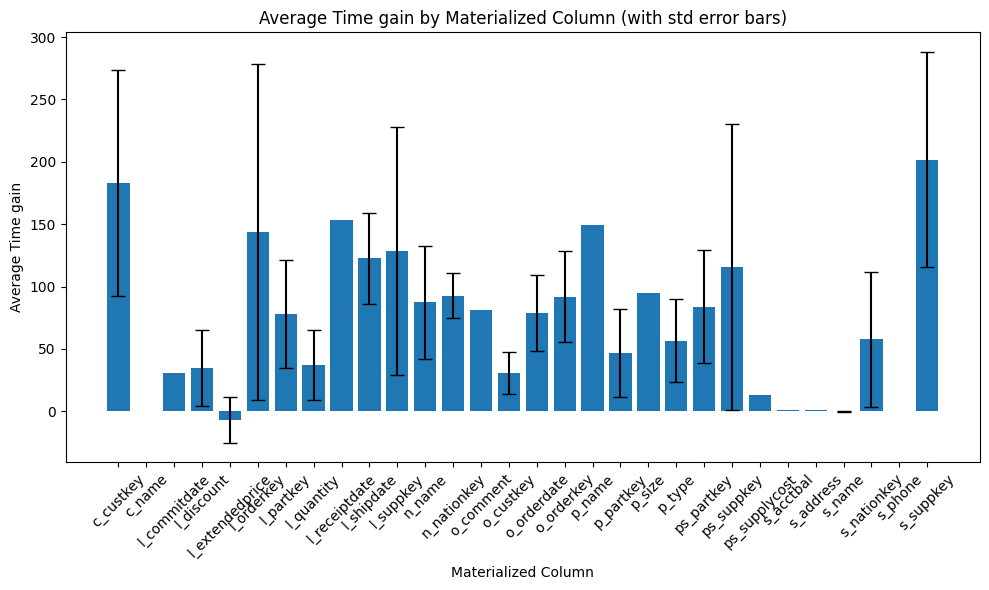

In [187]:
import matplotlib.pyplot as plt
import numpy as np

# Compute aggregated statistics for Time gain by Materialized Column
grouped = results_df.groupby("Materialized Column")["Time gain"].agg(
    ['mean', 'std', 'min', 'max']).reset_index()

plt.figure(figsize=(10, 6))
plt.bar(grouped["Materialized Column"],
        grouped["mean"], yerr=grouped["std"], capsize=5)
plt.xlabel("Materialized Column")
plt.ylabel("Average Time gain")
plt.title("Average Time gain by Materialized Column (with std error bars)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/0j/09kq_s112r5gz6_30yv10dwr0000gn/T/ipykernel_87020/2603369058.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


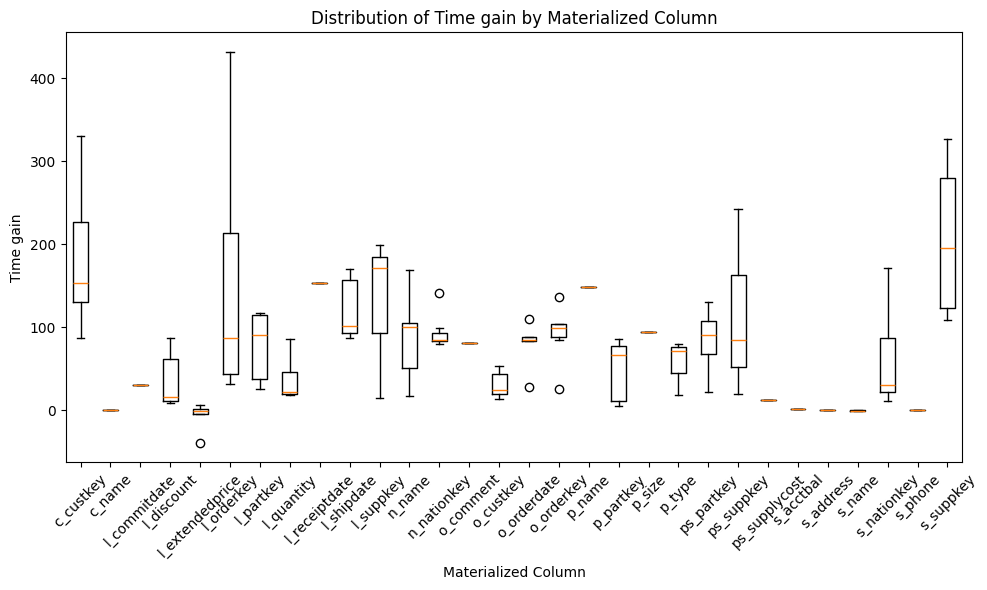

In [188]:
plt.figure(figsize=(10, 6))
# Prepare data: one list of Time gain values per Materialized Column
data = [group["Time gain"].values for _,
        group in results_df.groupby("Materialized Column")]
labels = sorted(results_df["Materialized Column"].unique())
plt.boxplot(data, labels=labels)
plt.xlabel("Materialized Column")
plt.ylabel("Time gain")
plt.title("Distribution of Time gain by Materialized Column")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

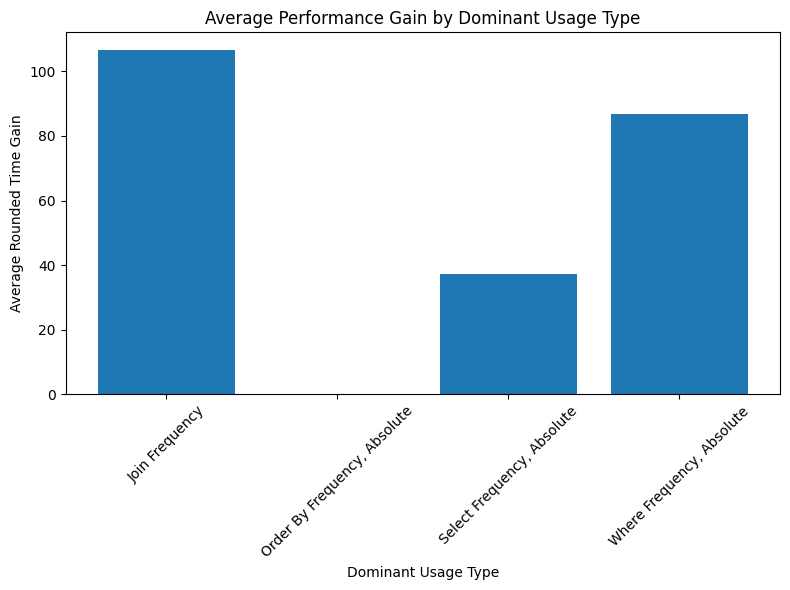

In [192]:
import matplotlib.pyplot as plt

# Define the frequency usage columns
usage_cols = [
    'Join Frequency',
    'Where Frequency, Absolute',
    'Select Frequency, Absolute',
    'Group By Frequency, Absolute',
    'Order By Frequency, Absolute'
]

# Compute the dominant usage type for each row


def dominant_usage(row):
    # idxmax returns the column name with the maximum value among the usage columns
    return row[usage_cols].idxmax()


results_df['Dominant Usage'] = results_df.apply(dominant_usage, axis=1)

# Group by the dominant usage and compute the average Rounded time gain
grouped_usage = results_df.groupby('Dominant Usage')[
    'Rounded time gain'].mean()

plt.figure(figsize=(8, 6))
plt.bar(grouped_usage.index, grouped_usage.values)
plt.xlabel('Dominant Usage Type')
plt.ylabel('Average Rounded Time Gain')
plt.title('Average Performance Gain by Dominant Usage Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:      Rounded time gain   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     10.74
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           1.08e-08
Time:                        15:17:06   Log-Likelihood:                -783.49
No. Observations:                 140   AIC:                             1579.
Df Residuals:                     134   BIC:                             1597.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

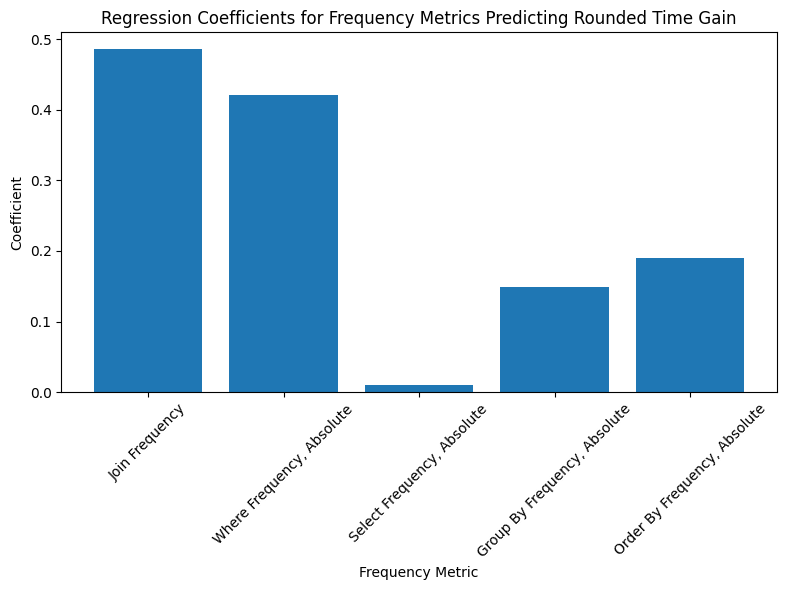

In [194]:
import statsmodels.api as sm

# Prepare the predictor variables and the target
X = results_df[usage_cols]
y = results_df['Rounded time gain']
X = sm.add_constant(X)  # add an intercept

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())

# Plot the regression coefficients (ignoring the constant)
coefs = model.params[1:]

plt.figure(figsize=(8, 6))
plt.bar(coefs.index, coefs.values)
plt.xlabel('Frequency Metric')
plt.ylabel('Coefficient')
plt.title(
    'Regression Coefficients for Frequency Metrics Predicting Rounded Time Gain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/0j/09kq_s112r5gz6_30yv10dwr0000gn/T/ipykernel_87020/35692886.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_data, labels=labels)


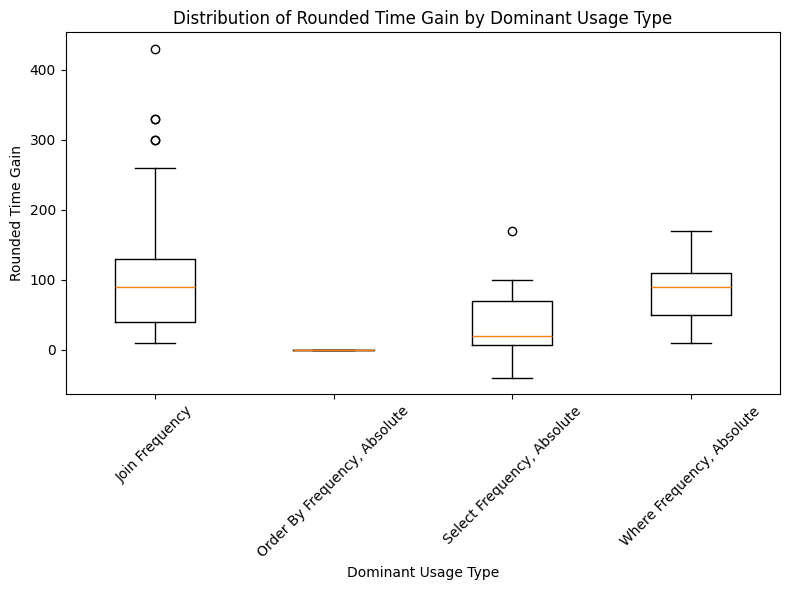

In [196]:
# Group the data by Dominant Usage and extract the Rounded time gain values
grouped_data = [group['Rounded time gain'].values for name,
                group in results_df.groupby('Dominant Usage')]
labels = list(results_df.groupby('Dominant Usage').groups.keys())

plt.figure(figsize=(8, 6))
plt.boxplot(grouped_data, labels=labels)
plt.xlabel('Dominant Usage Type')
plt.ylabel('Rounded Time Gain')
plt.title('Distribution of Rounded Time Gain by Dominant Usage Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()